In [2]:
#imports

from scipy.optimize import fsolve
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# CONSTANTS

# This constant assumes that if you place m items in b bins, (for m >> b) the max load of each bin will be c*m/b, with high probability
BINNING_CONSTANT = 4

PAILLIER_MODULUS_BIT_SIZE = 3072
PAILLIER_MODULUS_SIZE_IN_BYTES = PAILLIER_MODULUS_BIT_SIZE // 8

PAILLIER_INPUT_CT_SIZE_IN_BYTES = 128/8 + PAILLIER_MODULUS_SIZE_IN_BYTES
PAILLIER_OUTPUT_CT_SIZE_IN_BYTES = 2 * PAILLIER_MODULUS_SIZE_IN_BYTES

def B_to_KB(x):
    return x // 1024

def list_B_to_KB(x):
    return [B_to_KB(y) for y in x]

## Parameters of BasicPIRwithRLWE

In [3]:
# Evaluation Key Sizes
# These numbers are for N=4096 specifically
# To change the paremeters, the numbers have to be updated
RLWE_LOG2_N = 12
RLWE_N = 2 ** RLWE_LOG2_N
RLWE_LOG2_P = 18
MAX_PLAINTEXT_BITSIZE = RLWE_N * RLWE_LOG2_P

# Key sizes are in bytes
RLWE_EVAL_KEY_SIZE = dict()
RLWE_EVAL_KEY_SIZE[0] = 6
RLWE_EVAL_KEY_SIZE[1] = 131198
RLWE_EVAL_KEY_SIZE[2] = 262390
RLWE_EVAL_KEY_SIZE[3] = 393582
RLWE_EVAL_KEY_SIZE[4] = 524774
RLWE_EVAL_KEY_SIZE[5] = 655966
RLWE_EVAL_KEY_SIZE[6] = 787158
RLWE_EVAL_KEY_SIZE[7] = 918350
RLWE_EVAL_KEY_SIZE[8] = 1049542
RLWE_EVAL_KEY_SIZE[9] = 1180734
RLWE_EVAL_KEY_SIZE[10] = 1311926
RLWE_EVAL_KEY_SIZE[11] = 1443118
RLWE_EVAL_KEY_SIZE[12] = 1574310

INPUT_CT_SIZE = 65843
OUTPUT_CT_SIZE = 65843


ONIONPIR_EVAL_KEY_SIZE = dict()
ONIONPIR_EVAL_KEY_SIZE[0] = 32824
ONIONPIR_EVAL_KEY_SIZE[1] = 229770
ONIONPIR_EVAL_KEY_SIZE[2] = 426716
ONIONPIR_EVAL_KEY_SIZE[3] = 623662
ONIONPIR_EVAL_KEY_SIZE[4] = 820608
ONIONPIR_EVAL_KEY_SIZE[5] = 1017554
ONIONPIR_EVAL_KEY_SIZE[6] = 1214500
ONIONPIR_EVAL_KEY_SIZE[7] = 1411446
ONIONPIR_EVAL_KEY_SIZE[8] = 1608392
ONIONPIR_EVAL_KEY_SIZE[9] = 1805338
ONIONPIR_EVAL_KEY_SIZE[10] = 2002284
ONIONPIR_EVAL_KEY_SIZE[11] = 2199230
ONIONPIR_EVAL_KEY_SIZE[12] = 2396176


## Finding the communication cost of BasicPIRwithRLWE

In [7]:
# Communication cost of Base Algorithms

def comm_cost_BasicPIRwithPaillier(num_rows, payload_size_in_bytes):
  query_size = num_rows * PAILLIER_INPUT_CT_SIZE_IN_BYTES
  response_size = math.ceil(payload_size_in_bytes/PAILLIER_MODULUS_SIZE_IN_BYTES) * PAILLIER_OUTPUT_CT_SIZE_IN_BYTES
  return query_size + response_size, query_size, response_size


def comm_cost_BasicPIRwithRLWE(num_rows, payload_size_in_bytes):
  log2_keys_to_send = min(math.ceil(math.log2(num_rows)), RLWE_LOG2_N)
  keys_size = RLWE_EVAL_KEY_SIZE[log2_keys_to_send]
  query_size = INPUT_CT_SIZE * math.ceil(num_rows / (2**log2_keys_to_send))
  response_size = math.ceil(8*payload_size_in_bytes/MAX_PLAINTEXT_BITSIZE) * OUTPUT_CT_SIZE
  
  return keys_size + query_size + response_size, query_size, response_size, keys_size

def trivial_pir_cost(input_m, payload_size_in_bytes):
  return (input_m * payload_size_in_bytes)

# Communicaion Cost of Base algorithms with Binning

def comm_cost_BasicPIRwithPaillier_with_B_bins(input_m, B, payload_size_in_bytes):

  # query_size = PAILLIER_INPUT_CT_SIZE_IN_BYTES * B  
  # max_load = BINNING_CONSTANT * input_m / B
  # response_size = math.ceil(max_load*payload_size_in_bytes/PAILLIER_MODULUS_SIZE_IN_BYTES) * PAILLIER_OUTPUT_CT_SIZE_IN_BYTES
  
  max_load = BINNING_CONSTANT * input_m / B  
  return comm_cost_BasicPIRwithPaillier(B, max_load*payload_size_in_bytes)

def find_optimal_number_of_bins_for_BasicPIRwithPaillier_with_binning(input_m, payload_size_in_bytes):
  
  best_B = math.floor(math.sqrt(BINNING_CONSTANT * input_m * payload_size_in_bytes * PAILLIER_OUTPUT_CT_SIZE_IN_BYTES / PAILLIER_MODULUS_SIZE_IN_BYTES))
  total_comm, _, _, = comm_cost_BasicPIRwithPaillier_with_B_bins(input_m, best_B, payload_size_in_bytes)
  return best_B, total_comm


# Computes the communication of BasicPIRwithRLWE when m items of size payload_size_in_bytes are stored in B bins
def comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, B, payload_size_in_bytes):
  max_load = BINNING_CONSTANT * input_m / B
  
  # keys_size = RLWE_EVAL_KEY_SIZE[min(math.ceil(math.log2(B)), RLWE_LOG2_N)]
  # query_size = INPUT_CT_SIZE * math.ceil(B / RLWE_N)
  # response_size = math.ceil(max_load*8*payload_size_in_bytes/MAX_PLAINTEXT_BITSIZE) * OUTPUT_CT_SIZE
  # This was the previous payload_size_in_bytes which was hardcoded
  # (40 + math.ceil(math.log2(input_m)))
  
  return comm_cost_BasicPIRwithRLWE(B, max_load*payload_size_in_bytes)

def find_optimal_number_of_bins_for_BasicPIRwithRLWE(input_m, payload_size_in_bytes):
  # This is calculated by a naive minimization of the communication cost formula
  # it may not be the optimal solution so we check some other options in for loop as well
  potential_best_B = math.floor(math.sqrt(BINNING_CONSTANT * input_m * payload_size_in_bytes * RLWE_N * OUTPUT_CT_SIZE / INPUT_CT_SIZE))
  
  arg_min_B = potential_best_B
  min_total, _, _, _ = comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, potential_best_B, payload_size_in_bytes)
  
  # if input_m > 100000:
  #   print(potential_best_B, min_total//100000)
  for candidate_ceil_log2_B in range(RLWE_LOG2_N, 0, -1):
    
    chosen_B = min(potential_best_B, 2**candidate_ceil_log2_B)
    total_comm, _, _, _ = comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, chosen_B, payload_size_in_bytes)
    # if input_m > 100000:
    #   print(chosen_B, total_comm//100000)
    
    if min_total > total_comm:
      min_total = total_comm
      arg_min_B = chosen_B
    # print("log2_B: ", log2_B, "total size: ", (query_size + keys_size + response_size)//1024, "KB")
  
  return arg_min_B, min_total

## Plots for PrivateProviderRecords and PrivateWantHave
We can use the same graphs for the two cases

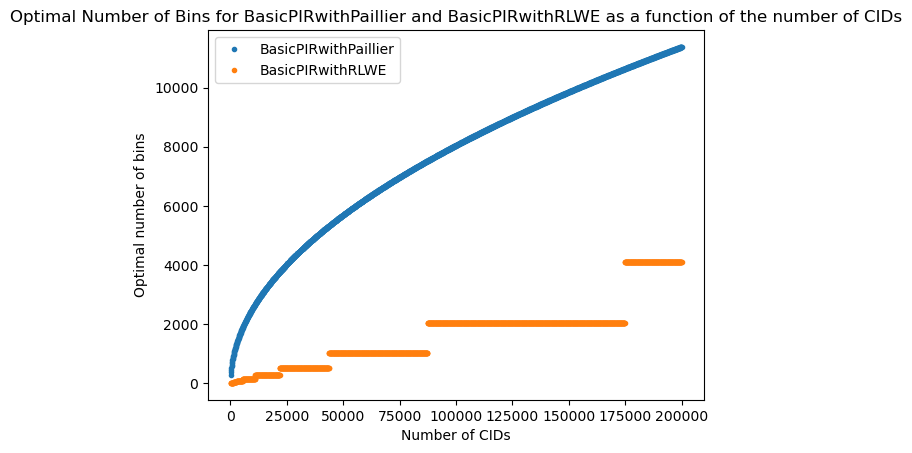

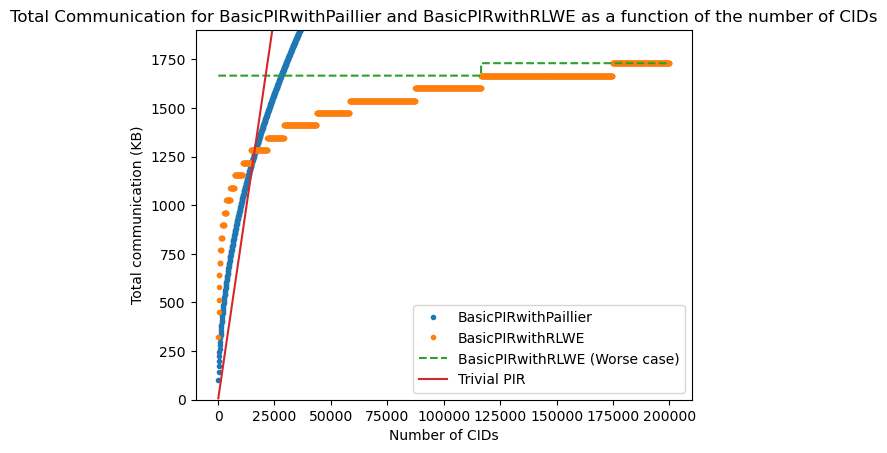

<Figure size 640x480 with 0 Axes>

In [8]:

ITEM_SIZES_IN_BYTES = 81
m_list = np.arange(100, 200000, 100)
# cropped_m_list = np.arange(100, 80000, 100)

num_bins_BasicPIRwithPaillier_list = []
per_bin_payload_size_basicpirwithpaillier = []
total_comm_BasicPIRwithPaillier_list = []

num_bins_BasicPIRwithRLWE_list = []
per_bin_payload_size_basicpirwithrlwe = []
total_comm_BasicPIRwithRLWE_list = []

total_comm_BasicPIRwithRLWE_worst_case_list = []

for input_m in m_list:
  
  optimal_B, total_comm = find_optimal_number_of_bins_for_BasicPIRwithPaillier_with_binning(input_m, ITEM_SIZES_IN_BYTES)
  num_bins_BasicPIRwithPaillier_list.append(optimal_B)
  per_bin_payload_size_basicpirwithpaillier.append(ITEM_SIZES_IN_BYTES * input_m * BINNING_CONSTANT / optimal_B)
  total_comm_BasicPIRwithPaillier_list.append(total_comm)
  
  optimal_B, total_comm = find_optimal_number_of_bins_for_BasicPIRwithRLWE(input_m, ITEM_SIZES_IN_BYTES)
  num_bins_BasicPIRwithRLWE_list.append(optimal_B)
  per_bin_payload_size_basicpirwithrlwe.append(ITEM_SIZES_IN_BYTES * input_m * BINNING_CONSTANT / optimal_B)
  total_comm_BasicPIRwithRLWE_list.append(total_comm)
  
  worst_case_BasicPIRwithRLWE, _, _, _ = comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, 2**RLWE_LOG2_N, ITEM_SIZES_IN_BYTES)
  total_comm_BasicPIRwithRLWE_worst_case_list.append(worst_case_BasicPIRwithRLWE)
  
trivial_pir_cost_list = [trivial_pir_cost(m, ITEM_SIZES_IN_BYTES) for m in m_list]
  
plt.plot(m_list, num_bins_BasicPIRwithPaillier_list, ".", label='BasicPIRwithPaillier')
plt.plot(m_list, num_bins_BasicPIRwithRLWE_list, ".", label='BasicPIRwithRLWE')
plt.xlabel("Number of CIDs")
plt.ylabel("Optimal number of bins")
plt.title("Optimal Number of Bins for BasicPIRwithPaillier and BasicPIRwithRLWE as a function of the number of CIDs")
plt.legend()
# plt.savefig("num_bins_pir_with_binning.png")
plt.show()
plt.clf()

plt.plot(m_list, list_B_to_KB(total_comm_BasicPIRwithPaillier_list), ".", label='BasicPIRwithPaillier')
plt.plot(m_list, list_B_to_KB(total_comm_BasicPIRwithRLWE_list), ".", label='BasicPIRwithRLWE')
plt.plot(m_list, list_B_to_KB(total_comm_BasicPIRwithRLWE_worst_case_list), "--", label='BasicPIRwithRLWE (Worse case)')
plt.plot(m_list, list_B_to_KB(trivial_pir_cost_list), label='Trivial PIR')
plt.xlabel("Number of CIDs")
plt.ylabel("Total communication (KB)")
plt.ylim(0, 1900)
plt.title("Total Communication for BasicPIRwithPaillier and BasicPIRwithRLWE as a function of the number of CIDs")
plt.legend()
# plt.savefig("total_comm_pir_with_binning.png")
plt.show()
plt.clf()

# make a csv file out of the three lists
pd.DataFrame({
  'm': m_list,
  'num_bins_basicpirwithrlwe': num_bins_BasicPIRwithRLWE_list,
  'num_bins_basicpirwithpaillier': num_bins_BasicPIRwithPaillier_list,
  'per_bin_payload_size_basicpirwithrlwe': per_bin_payload_size_basicpirwithrlwe,
  'per_bin_payload_size_basicpirwithpaillier': per_bin_payload_size_basicpirwithpaillier,
  'total_comm_basicpirwithrlwe': list_B_to_KB(total_comm_BasicPIRwithRLWE_list),
  'total_comm_basicpirwithpaillier': list_B_to_KB(total_comm_BasicPIRwithPaillier_list),
  "total_comm_basicpirwithrlwe_worst_case": list_B_to_KB(total_comm_BasicPIRwithRLWE_worst_case_list),
  "trivial_pir_cost": list_B_to_KB(trivial_pir_cost_list)
}).to_csv("results_pir_with_bins.csv", index=False)


In [65]:
print("Paillier", min(per_bin_payload_size_basicpirwithpaillier), max(per_bin_payload_size_basicpirwithpaillier))
print("RLWE", min(per_bin_payload_size_basicpirwithrlwe), max(per_bin_payload_size_basicpirwithrlwe))

Paillier 127.55905511811024 8049.176865254395
RLWE 8100.0 51194.53125


## Plots for PrivatePeerRouting
Communiction Costs of PIR over the Routing Table

In [53]:
# paillier_modulus_bit_size = 3072
# pallier_modulus_size_in_bytes = paillier_modulus_bit_size // 8

# number_of_rows = 40

# def trivial_pir_cost_in_KB(number_of_rows, ROW_SIZE_IN_BYTES):
#   return (number_of_rows * ROW_SIZE_IN_BYTES)/1024

# def paillier_pir_cost_in_KB(number_of_rows, ROW_SIZE_IN_BYTES):
#   return (number_of_rows * PAILLIER_INPUT_CT_SIZE_IN_BYTES + PAILLIER_OUTPUT_CT_SIZE_IN_BYTES * math.ceil(ROW_SIZE_IN_BYTES / PAILLIER_MODULUS_SIZE_IN_BYTES))/1024

# def basicpir_with_rlwe_cost_in_KB(number_of_rows, ROW_SIZE_IN_BYTES):
#   log2_num_rows = math.ceil(math.log2(number_of_rows))
#   return (math.ceil(number_of_rows/RLWE_N) * INPUT_CT_SIZE + RLWE_EVAL_KEY_SIZE[min(log2_num_rows, 12)] + math.ceil(ROW_SIZE_IN_BYTES / (RLWE_N * RLWE_LOG2_P)) * OUTPUT_CT_SIZE)/1024


In [26]:
ROW_SIZE_IN_BYTES = 20 * 81

rows_range = range(4,257)
trivial_PIR_cost_list = [B_to_KB(trivial_pir_cost(n, ROW_SIZE_IN_BYTES)) for n in rows_range]
paillier_pir_cost_list = [B_to_KB(comm_cost_BasicPIRwithPaillier(n, ROW_SIZE_IN_BYTES)[0]) for n in rows_range]
paillier_worst_case_cost_list = [B_to_KB(comm_cost_BasicPIRwithPaillier(256, ROW_SIZE_IN_BYTES)[0]) for _ in rows_range]
basicpir_with_rlwe_cost_list = [B_to_KB(comm_cost_BasicPIRwithRLWE(n, ROW_SIZE_IN_BYTES)[0]) for n in rows_range]
basicpir_with_rlwe_worst_case_cost_list = [B_to_KB(comm_cost_BasicPIRwithRLWE(256, ROW_SIZE_IN_BYTES)[0]) for n in rows_range]

plt.plot(rows_range, trivial_PIR_cost_list, label='TrivialPIR')
plt.plot(rows_range, paillier_pir_cost_list, label='BasicPIRwithPaillier')
plt.plot(rows_range, paillier_worst_case_cost_list, '--', label='BasicPIRwithPaillier (worst case)')
plt.plot(rows_range, basicpir_with_rlwe_cost_list, label='BasicPIRwithRLWE')
plt.plot(rows_range, basicpir_with_rlwe_worst_case_cost_list, '--', label='BasicPIRwithRLWE (worst case)')
plt.ylabel("Communication cost (KB)")
plt.xlabel("Number of rows in routing table")
plt.yscale('log')
plt.legend()
pd.DataFrame({
  'rows': rows_range,
  'trivial_PIR_cost': trivial_PIR_cost_list,
  'paillier_pir_cost': paillier_pir_cost_list,
  'paillier_worst_case_cost': paillier_worst_case_cost_list,
  'basicpir_with_rlwe_cost': basicpir_with_rlwe_cost_list,
  'basicpir_with_rlwe_worst_case_cost': basicpir_with_rlwe_worst_case_cost_list
}).to_csv("total_comm_pir_in_RT.csv", index=False)

SyntaxError: invalid syntax (53602757.py, line 25)

In [23]:
ROW_SIZE_IN_BYTES = 256 * 1024

log_rows_range = range(10, 19)
basicpir_with_rlwe_cost_list = [B_to_KB(comm_cost_BasicPIRwithRLWE(2**log_n, ROW_SIZE_IN_BYTES)[0]) for log_n in log_rows_range]
pd.DataFrame({
  'log2_rows': log_rows_range,
  'basicpir_with_rlwe_cost': basicpir_with_rlwe_cost_list
}).to_csv("total_comm_256_KB_rlwe.csv", index=False)